Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data

#### Importing all the important *libraries*

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# mount Google Drive.
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment.zip" > /dev/null

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [6]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

In [8]:
#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

##### Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

# Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split = 0.2, subset = "training", seed = 123,
                                                               image_size = (img_height, img_width), batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split = 0.2, subset = "validation",
                                                             seed = 123, image_size = (img_height, img_width), batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
##### Todo, create a code to visualize one instance of all the nine classes present in the dataset

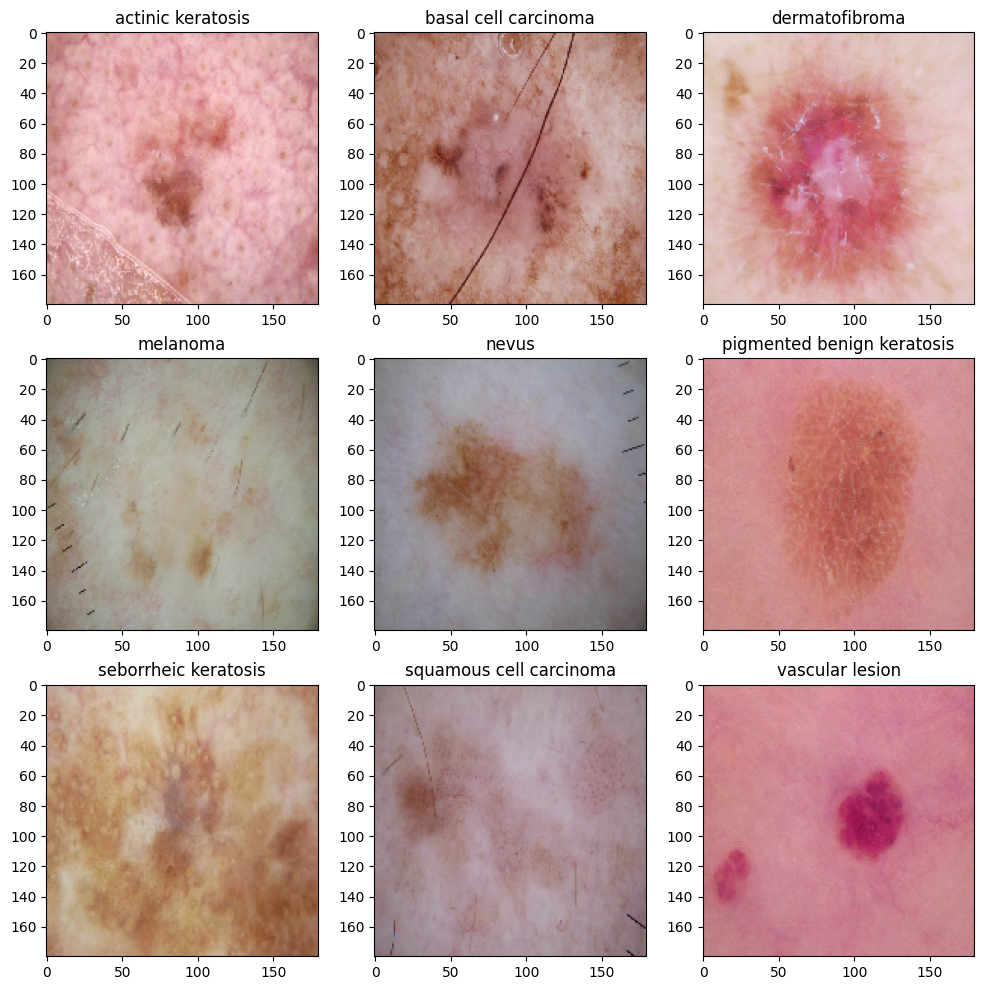

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(12,12))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Count of each Class categories

def class_distribution_count(directory):

    #count number of image in each classes
    count = []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,vascular lesion,139
2,seborrheic keratosis,77
3,basal cell carcinoma,376
4,dermatofibroma,95
5,melanoma,438
6,nevus,357
7,squamous cell carcinoma,181
8,actinic keratosis,114


<ipython-input-16-13d718f3efe4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="No. of Image", y="Class", data=df, palette = "nipy_spectral")


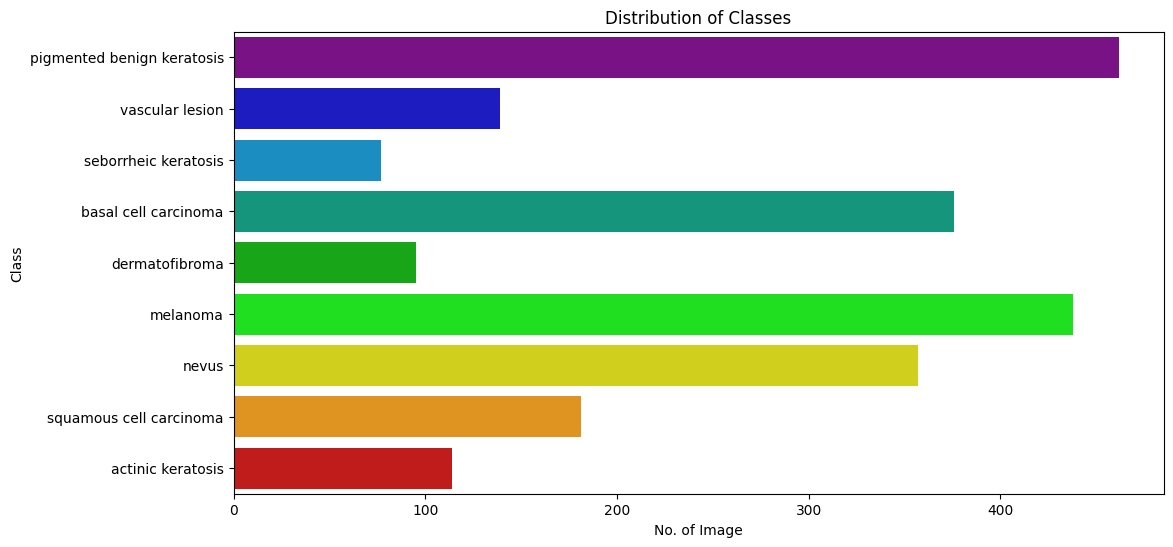

In [16]:
#Visualize the Number of image in each class

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x="No. of Image", y="Class", data=df, palette = "nipy_spectral")
plt.title('Distribution of Classes')
plt.show()

### Create the model
##### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Activation

model = Sequential()
# Normalizing pixel valuse between 0 and 1
model.add(Rescaling(1./255, input_shape = (180, 180, 3)))

# Add convolutional layer
model.add(Conv2D(32, (3, 3), activation = 'relu')) # 32 filters

# Max Pool Layer
model.add(MaxPooling2D(2, 2))

# 2nd convolutional layer
model.add(Conv2D(64, (3, 3))) # 64 filters
model.add(Activation('relu'))

# Batch normalization
model.add(layers.BatchNormalization())

# 2nd Max Pool Layer
model.add(MaxPooling2D(2, 2))

# 3rd convolutional layer
model.add(Conv2D(128, (3, 3))) # 128 filters
model.add(Activation('relu'))

# Batch normalization
model.add(layers.BatchNormalization())

# 3rd Max Pool Layer
model.add(MaxPooling2D(2, 2))

# Flattening the feature maps
model.add(Flatten())

# Fully connected layers with 256 neurons
model.add(Dense(256))
model.add(Activation('relu'))

# Using softmax for outputlayer for 9 classes
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

# View the summary of all layers
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 41, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,203,785 (50.37 MB)

 Trainable params: 13,203,401 (50.37 MB)

 Non-trainable params: 384 (1.50 KB)

### Compile the model
Choose an appropirate optimiser and loss function for model training

SGD: SGD is simple and efficient, especially for large datasets. It can converge quickly, even in complex scenarios.

sparse_categorical_crossentropyproduces a category index of the most likely matching categories.

In [18]:
### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.optimizers import SGD

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 41, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,203,785 (50.37 MB)

 Trainable params: 13,203,401 (50.37 MB)

 Non-trainable params: 384 (1.50 KB)

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.2828 - loss: 3.9086 - val_accuracy: 0.1499 - val_loss: 2.4857
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4931 - loss: 1.4076 - val_accuracy: 0.1499 - val_loss: 3.2868
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5936 - loss: 1.1647 - val_accuracy: 0.1879 - val_loss: 2.9979
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7059 - loss: 0.8275 - val_accuracy: 0.1566 - val_loss: 3.7685
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7725 - loss: 0.6393 - val_accuracy: 0.1991 - val_loss: 3.6890
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8298 - loss: 0.5090 - val_accuracy: 0.2506 - val_loss: 3.3057
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8749 - loss: 0.3544 - val_accuracy: 0.2595 - val_loss: 3.5464
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8916 - loss: 0.3346 - val_accuracy: 0.3848 -

### Visualizing training results

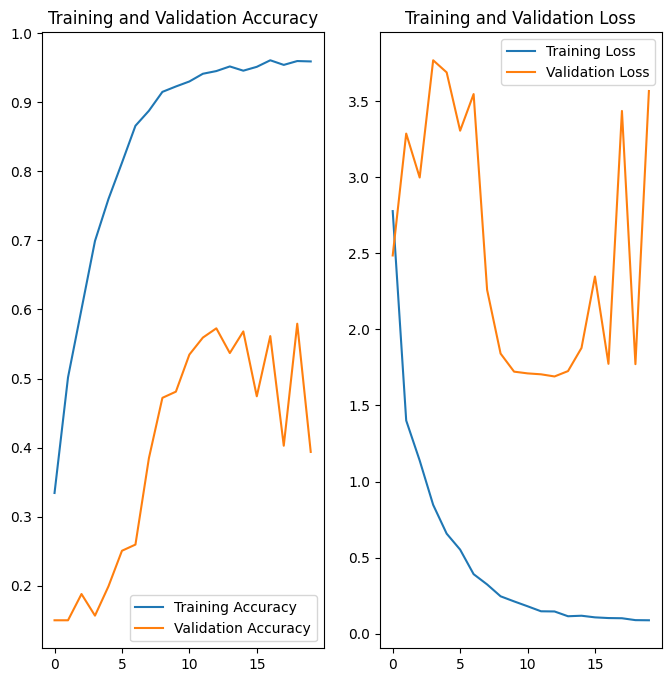

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

#### Observations from the model fit history


##### **Overfitting is present** as **training accuracy** consistantly increases to **97.07% (max)** while **validation accuracy** reaches **57.94% (max)**.

##### Validation accuracy improves significantly from epoch 3. However it begins to fluctuate, **suggesting overfitting**



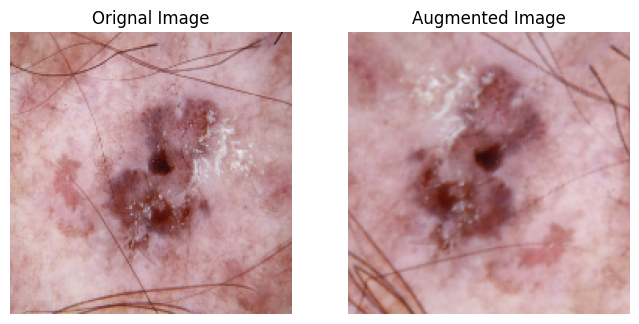

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

# Data Augumentation Layer
rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)])

# Visualize Augmentation Strategy with One instance
for images, lables in train_ds.take(1):
    image = images[0]
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    augmented_image = augmented_image[0].numpy().astype("uint8")

    # Visualizing orignal and augmented images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Orignal Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Augmented Image")
    plt.axis("off")

    plt.show()

In [24]:
### Todo:
### Create the model, compile and train the model

In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model2 = Sequential()                     # Sequential allows you to create models layer-by-layer
model2.add(data_augmentation)             # Applying data augmentation layer

# Normalizing pixel valuse between 0 and 1
model2.add(Rescaling(1./255, input_shape = (180, 180, 3)))

# Add convolutional layer
model2.add(Conv2D(32, (3, 3), activation = 'relu')) # 32 filters

# Batch normalization
model2.add(layers.BatchNormalization())

# Max Pool Layer
model2.add(MaxPooling2D(2, 2))

# 2nd convolutional layer
model2.add(Conv2D(64, (3, 3))) # 64 filters
model2.add(Activation('relu'))

# Batch normalization
model2.add(layers.BatchNormalization())

# 2nd Max Pool Layer
model2.add(MaxPooling2D(2, 2))

# 3rd convolutional layer
model2.add(Conv2D(128, (3, 3))) # 128 filters
model2.add(Activation('relu'))

# Batch normalization
model2.add(layers.BatchNormalization())

# 3rd Max Pool Layer
model2.add(MaxPooling2D(2, 2))

# 4th convolutional layer
model2.add(Conv2D(256, (3, 3))) # 256 filters
model2.add(Activation('relu'))

# Batch normalization
model2.add(layers.BatchNormalization())

# 4th Max Pool Layer
model2.add(MaxPooling2D(2, 2))

# Flattening the feature maps
model2.add(Flatten())

# Dropout layer with 50% Fraction of the input
model2.add(layers.Dropout(0.50))

# Fully connected layers with 256 neurons
model2.add(Dense(256))
model2.add(Activation('relu'))

# Batch normalization
model2.add(layers.BatchNormalization())


# Using softmax for outputlayer for 9 classes
model2.add(Dense(len(class_names)))
model2.add(Activation('softmax'))

# View the summary of all layers
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (1, 180, 180, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (1, 178, 178, 32)           │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 178, 178, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (1, 89, 89, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (1, 87, 87, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (1, 87, 87, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (1, 87, 87, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (1, 43, 43, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (1, 41, 41, 128)            │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (1, 41, 41, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (1, 41, 41, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (1, 20, 20, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (1, 18, 18, 256)            │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (1, 18, 18, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (1, 18, 18, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (1, 9, 9, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (1, 20736)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 20736)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,702,345 (21.75 MB)

 Trainable params: 5,700,873 (21.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [26]:
### Compiling the model

In [27]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.3089 - loss: 2.2808 - val_accuracy: 0.0537 - val_loss: 2.4341
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.4754 - loss: 1.6137 - val_accuracy: 0.0537 - val_loss: 2.6915
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5110 - loss: 1.4544 - val_accuracy: 0.1499 - val_loss: 2.8651
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.5600 - loss: 1.3237 - val_accuracy: 0.1521 - val_loss: 2.8935
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5572 - loss: 1.2528 - val_accuracy: 0.2058 - val_loss: 2.6761
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5876 - loss: 1.1819 - val_accuracy: 0.2371 - val_loss: 2.3275
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6172 - loss: 1.1427 - val_accuracy: 0.3154 - val_loss: 2.4939
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.6149 - loss: 1.0928 - val_accuracy: 0.4340 - v

### Visualizing the results

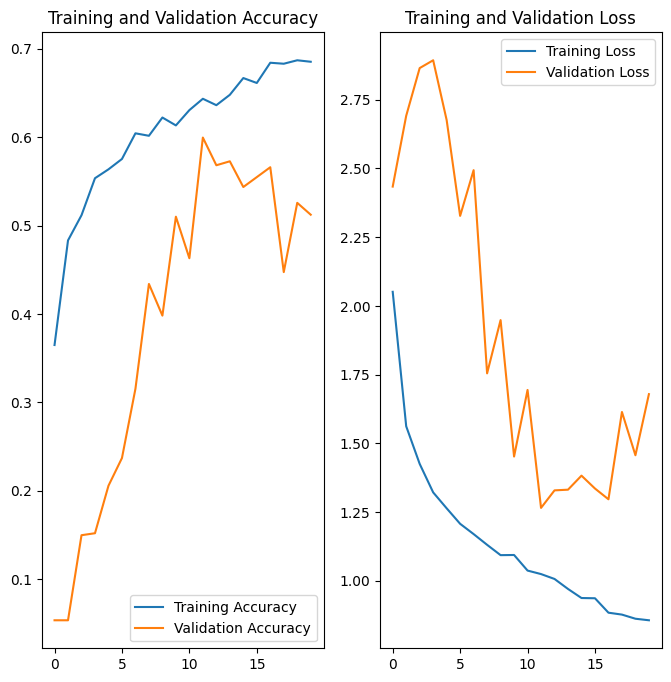

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


#### **Observation:** After introducing dropouts, additional filter and data agumentation the overfitting issue is reduced but model performace has decreased. Post Epoch 9 the gap between training accuracy and Validation accuracy reduced drastically. Need to check the distribution of classes in the training set tocheck is there have class imbalance.

#### So in all the updated model shows improved generalization compared to the previous fit

In [57]:
#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### Class Imbalance Detection

In [31]:
## Your code goes here.

def class_distribution_count(directory):

    #count number of image in each classes
    count = []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,vascular lesion,139
2,seborrheic keratosis,77
3,basal cell carcinoma,376
4,dermatofibroma,95
5,melanoma,438
6,nevus,357
7,squamous cell carcinoma,181
8,actinic keratosis,114


<ipython-input-32-43b28be17bd0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="No. of Image", y="Class", data=df, palette = "nipy_spectral")


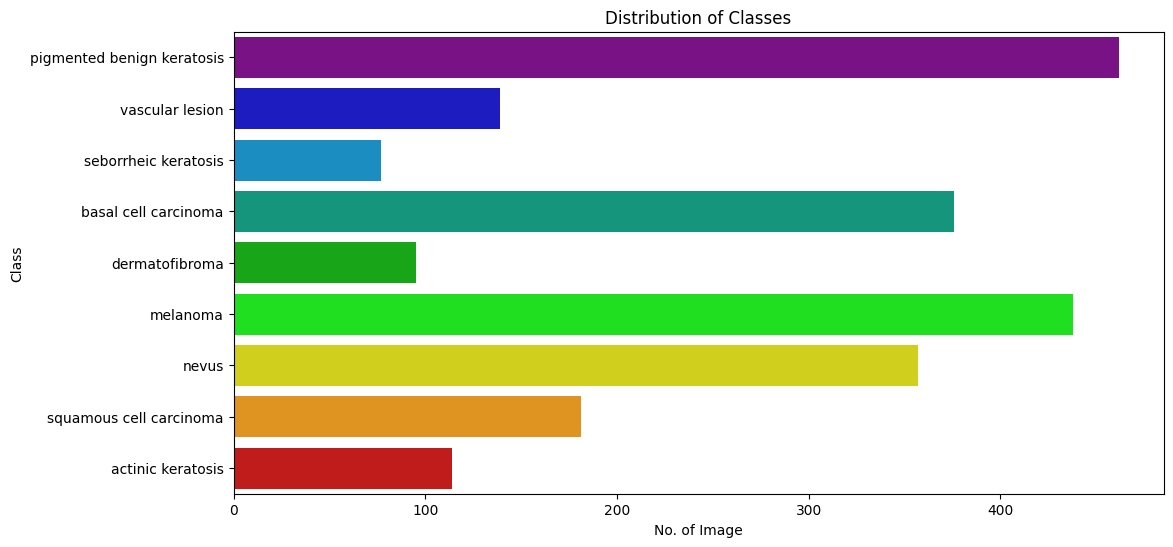

In [32]:
#Visualize the Number of image in each class

plt.figure(figsize=(12, 6))
sns.barplot(x="No. of Image", y="Class", data=df, palette = "nipy_spectral")
plt.title('Distribution of Classes')
plt.show()

#### **Todo:** Write your findings here:

#### **Q:** Which class has the least number of samples?
#### **Ans:** seborrheic keratosis has the least number of samples (**77**).


#### **Q:** Which classes dominate the data in terms proportionate number of samples?
#### **Ans:** pigmented benign keratosis (**462** Samples), melanoma (**438** Samples), basal cell carcinoma (**376** Samples), and nevus (**357** Samples) classes dominates the data in terms proportionate number of samples

In [33]:
#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [35]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F855D6DBD30>: 100%|██████████| 500/500 [00:21<00:00, 23.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F855D54A140>: 100%|██████████| 500/500 [00:17<00:00, 28.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F855D55BA30>: 100%|██████████| 500/500 [00:15<00:00, 32.07 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x7F855A00DED0>: 100%|██████████| 500/500 [01:16<00:00,  6.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F855DD135B0>: 100%|██████████| 500/500 [01:27<00:00,  5.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85D012C250>: 100%|██████████| 500/500 [00:15<00:00, 32.97 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F85D02A1720>: 100%|██████████| 500/500 [00:36<00:00, 13.65 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F855DED72E0>: 100%|██████████| 500/500 [00:16<00:00, 29.43 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85D0119570>: 100%|██████████| 500/500 [00:15<00:00, 32.10 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028233.jpg_82c048f4-4a2d-494c-a868-c7e911611884.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027953.jpg_582ea46e-7873-4a3b-a7fb-4bb64e8808e6.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025485.jpg_0a0114c1-0746-4dfd-8164-60a386db2364.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024612.jpg_6c4114f1-2f31-4e61-bd44-1d43d5e56e37.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027905.jp

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [41]:
#label count.
df2['Label'].value_counts()

,count
Label,
pigmented benign keratosis,500
vascular lesion,500
seborrheic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
squamous cell carcinoma,500
actinic keratosis,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [43]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create your model (make sure to include normalization)

In [45]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model3 = Sequential()                     # Sequential allows you to create models layer-by-layer

# Normalizing pixel valuse between 0 and 1
model3.add(Rescaling(1./255, input_shape = (180, 180, 3)))

# Add convolutional layer
model3.add(Conv2D(32, (3, 3), activation = 'relu')) # 32 filters

# Batch normalization
model3.add(layers.BatchNormalization())

# Max Pool Layer
model3.add(MaxPooling2D(2, 2))

# 2nd convolutional layer
model3.add(Conv2D(64, (3, 3))) # 64 filters
model3.add(Activation('relu'))

# Batch normalization
model3.add(layers.BatchNormalization())

# 2nd Max Pool Layer
model3.add(MaxPooling2D(2, 2))

# 3rd convolutional layer
model3.add(Conv2D(128, (3, 3))) # 128 filters
model3.add(Activation('relu'))

# Batch normalization
model3.add(layers.BatchNormalization())

# 3rd Max Pool Layer
model3.add(MaxPooling2D(2, 2))

# 4th convolutional layer
model3.add(Conv2D(256, (3, 3))) # 256 filters
model3.add(Activation('relu'))

# Batch normalization
model3.add(layers.BatchNormalization())

# 4th Max Pool Layer
model3.add(MaxPooling2D(2, 2))

# Flattening the feature maps
model3.add(Flatten())

# Dropout layer with 50% Fraction of the input
model3.add(layers.Dropout(0.50))

# Fully connected layers with 256 neurons
model3.add(Dense(128))
model3.add(Activation('relu'))

# Batch normalization
model3.add(layers.BatchNormalization())


# Using softmax for outputlayer for 9 classes
model3.add(Dense(len(class_names)))
model3.add(Activation('softmax'))

# View the summary of all layers
model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 41, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,046,345 (11.62 MB)

 Trainable params: 3,045,129 (11.62 MB)

 Non-trainable params: 1,216 (4.75 KB)

### Compile your model (Choose optimizer and loss function appropriately)

In [46]:
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

### Train your model

In [47]:
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=35
)

Epoch 1/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.3543 - loss: 1.9246 - val_accuracy: 0.1151 - val_loss: 2.5873
Epoch 2/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.5933 - loss: 1.1081 - val_accuracy: 0.1804 - val_loss: 2.4415
Epoch 3/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.6780 - loss: 0.9037 - val_accuracy: 0.4952 - val_loss: 1.4412
Epoch 4/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - accuracy: 0.7428 - loss: 0.7432 - val_accuracy: 0.7431 - val_loss: 0.7606
Epoch 5/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 169ms/step - accuracy: 0.7853 - loss: 0.6213 - val_accuracy: 0.5561 - val_loss: 1.2638
Epoch 6/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.8136 - loss: 0.5416 - val_accuracy: 0.5085 - val_loss: 1.3934
Epoch 7/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - accuracy: 0.8499 - loss: 0.4613 - val_accuracy: 0.5880 - val_loss: 1.2205
Epoch 8/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.8626 - loss: 0

### Visualize the model results

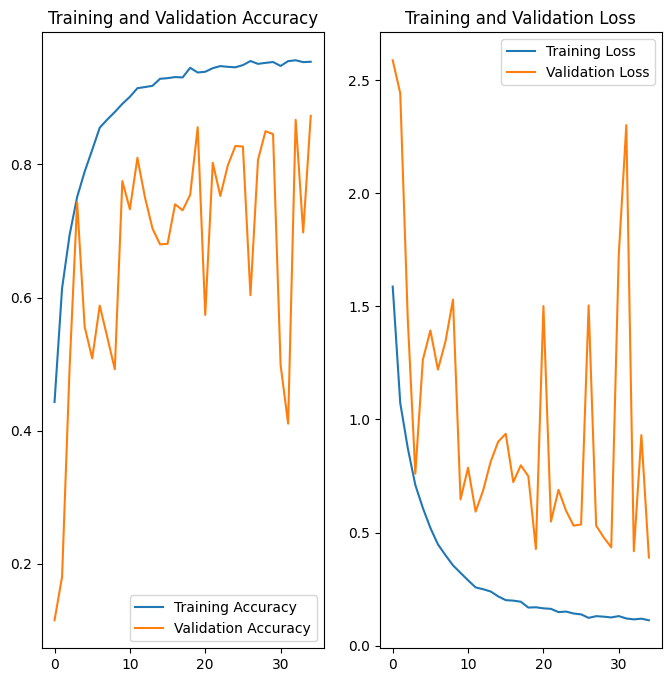

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(35)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

##### **The model shows significant improvement in both training and validation performance**, benefiting from the handling of class imbalance and an extended training period. While there are minor signs of overfitting during some epochs, the overall trend shows a strong model capable of generalizing well, achieving a final validation accuracy of **87.31%**.

### Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Actual Class actinic keratosis
Predictive Class actinic keratosis


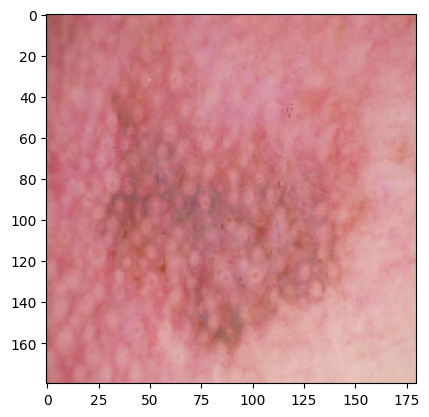

In [73]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[0], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[0],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model3.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[0] +'\n'+ "Predictive Class "+pred_class )